In [2]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
import math

#**Exercise 1: Matrix Factorization for Recommendation System**

We aim to minimize the following function:

$f\left(\{\mathbf{p}_u, \mathbf{q}_i\}_{(u,i) \in \mathcal{K}}\right) = \sum_{(u,i) \in \mathcal{K}} \left( ([\mathbf{X}]_{u,i} - \mathbf{p}_u^\top \mathbf{q}_i)^2 + \rho_1^{(u)} \|\mathbf{p}_u\|_2^2 + \rho_2^{(i)} \|\mathbf{q}_i\|_2^2 \right)
$

As a result, the optimization problem is stated as follows:

$\
\arg\min_{\mathbf{p}_u \in \mathbb{R}^d, \mathbf{q}_i \in \mathbb{R}^d} f\left(\{\mathbf{p}_u, \mathbf{q}_i\}_{(u,i) \in \mathcal{K}}\right) \ \ \ \   (1) \\
\text{s.t. } \mathbf{p}_u \in \mathbb{R}^d, \, \mathbf{q}_i \in \mathbb{R}^d, \quad \forall \, (u, i) \in \mathcal{K}
\
$

Where:

- Data matrix $\mathbf{X}$ of size $M \times N$, where $M = \text{number of users}$ and $N = \text{number of items}$  
- $[\mathbf{X}]_{u,i}$ is the rating (score) that user $u$ gave to item $i$  
- Recall: $[\mathbf{X}]_{u,i} = \mathbf{p}_u^\top \mathbf{q}_i$, where $\mathbf{p}_u \in \mathbb{R}^d$ is the vector of user preferences, and $\mathbf{q}_i \in \mathbb{R}^d$ is the vector of item characteristics  
- Use entries with known ratings as the training set, $(u, i) \in \mathcal{K}$  
- Entries of $\mathcal{K}$ satisfy the low-rank matrix factorization model: $[\mathbf{X}]_{u,i} = \mathbf{p}_u^\top \mathbf{q}_i, \, \forall (u, i) \in \mathcal{K}$
- $\{\rho_1^{(u)} > 0, \rho_2^{(i)} > 0\}_{(u,i) \in \mathcal{K}}$ are regularization parameters to prevent overfitting


**Algorithm:**
Due to the presence of coupling in the cost function, Block-Coordinate Descent
(BCD) methods are prevalent for solving the optmization problem. According to (1), we can derive each subproblem corresponding to each of the optimization variables by using BCD method.



*   First Step) Fixing $\mathbf{Q}$ and solving optimization problem for $\mathbf{p_u}$:

  $
  f\left(\{\mathbf{p}_u, \mathbf{q}_i\}_{(u,i) \in \mathcal{K}}\right) = \sum_{(u,i) \in \mathcal{K}} \left( ([\mathbf{X}]_{u,i} - \mathbf{p}_u^\top \mathbf{q}_i)^2 + \rho_1^{(u)} \|\mathbf{p}_u\|_2^2 + \rho_2^{(i)} \|\mathbf{q}_i\|_2^2 \right)
  $

  $
  \arg\min_{\mathbf{p}_u \in \mathbb{R}^d} f\left(\{\mathbf{p}_u, \mathbf{q}_i\}_{(u,i) \in \mathcal{K}}\right) = \arg\min_{\mathbf{p}_u \in \mathbb{R}^d} \sum_{i \in \mathcal{I_u}} \left( ([\mathbf{X}]_{u,i} - \mathbf{p}_u^\top \mathbf{q}_i)^2 + \rho_1^{(u)} \|\mathbf{p}_u\|_2^2 \right)
  $

  where $\mathcal{I_u}$ is the set of items (movies) rated by user $\mathcal{u}$

  For derivation of the closed form solution, we can compute the gradient and find the stationary point of the subproblem:

  $
  f(\mathbf{p}_u) = \sum_{i \in \mathcal{I_u}} \left( ([\mathbf{X}]_{u,i} - \mathbf{p}_u^\top \mathbf{q}_i)^2 + \rho_1^{(u)} \|\mathbf{p}_u\|_2^2 \right)
  $

  The gradient of $f(\mathbf{p}_u)$ with respect to $\mathbf{p}_u$ is:
  $
  \nabla_{\mathbf{p}_u} f(\mathbf{p}_u) = 2 \left( \sum_{i \in \mathcal{I_u}} \mathbf{q}_i \mathbf{q}_i^\top \mathbf{p}_u - \sum_{i \in \mathcal{I_u}} [\mathbf{X}]_{u,i} \mathbf{q}_i \right) + 2 \rho_1^{(u)} \mathbf{p}_u
  $

  $\nabla_{\mathbf{p}_u} f(\mathbf{p}_u) = 0$

  $
  \left( \sum_{i \in \mathcal{I_u}} \mathbf{q}_i \mathbf{q}_i^\top + \rho_1^{(u)} \mathbf{I} \right) \mathbf{p}_u = \sum_{i \in \mathcal{I_u}} [\mathbf{X}]_{u,i} \mathbf{q}_i
  $

  We get the closed-form solution:

  $
  \mathbf{p}_u = \left( \sum_{i \in \mathcal{I_u}} \mathbf{q}_i \mathbf{q}_i^\top + \rho_1^{(u)} \mathbf{I} \right)^{-1} \sum_{i \in \mathcal{I_u}} [\mathbf{X}]_{u,i} \mathbf{q}_i
  $

  This solution provides the optimal $\mathbf{p}_u$ for fixed $\mathbf{q}_i$.

  Now, we want to show that the subproblem is strong convex, requiring to compute the Hessian matrix:

  $
  \mathbf{H} = \nabla_{\mathbf{p}_u}^2 f(\mathbf{p}_u) = 2 \left( \sum_{i \in \mathcal{I_u}} \mathbf{q}_i \mathbf{q}_i^\top \right) + 2 \rho_1^{(u)} \mathbf{I}
  $

  Since $\rho_1^{(u)}>0$, and the matrix $\left( \sum_{i \in \mathcal{I_u}} \mathbf{q}_i \mathbf{q}_i^\top \right) + 2 \rho_1^{(u)}$ is positive definite. Therefore, the corresponding cost function is $\rho_1^{(u)}$-strongly convex.

*   Second Step) Fixing $\mathbf{P}$ and solving optimization problem for $\mathbf{q_i}$:

  $
  \arg\min_{\mathbf{q}_i \in \mathbb{R}^d} f\left(\{\mathbf{p}_u, \mathbf{q}_i\}_{(u,i) \in \mathcal{K}}\right) = \arg\min_{\mathbf{q}_i \in \mathbb{R}^d} \sum_{u \in \mathcal{U}_i} \left( ([\mathbf{X}]_{u,i} - \mathbf{p}_u^\top \mathbf{q}_i)^2 + \rho_2^{(i)} \|\mathbf{q}_i\|_2^2 \right)
  $

  where $\mathcal{U}_i$ is the set of users who rated item $\mathcal{i}$.

  The same as the first step, we can get the closed-form solution by setting the gradient of the corresponding cost function to zero:

  $
  \mathbf{q}_i = \left( \sum_{u \in \mathcal{U}_i} \mathbf{p}_u \mathbf{p}_u^\top + \rho_2^{(i)} \mathbf{I} \right)^{-1} \sum_{u \in \mathcal{U}_i} [\mathbf{X}]_{u,i} \mathbf{p}_u
  $

  In addition, we can prove that $f(\mathbf{q}_i)$ is $\rho_2^{(i)}$-strongly convex, as well as the first subproblem.

**Convergence Analysis:**

Since the Hessian matrix is positive definite, as we have proved in the last part, its eigen values are bounded. Hence, the cost function is $\mu$-strongly convex (it also shows that the solution for each subproblem is unique) and L-smooth. Moreover, the domain of the optimization problem is closed and convex ($\mathbb{R}^d$). Based on the theorem, which has been mentioned in the lecture classes, The sequence of updates generated by the CD method and the BCD method monotonically converges to a stationary point of f.

**Computational Complexity:**

The computatinal complexity for each iteration involves solving all subproblems:

$
  \mathbf{p}_u = \left( \sum_{i \in \mathcal{I_u}} \mathbf{q}_i \mathbf{q}_i^\top + \rho_1^{(u)} \mathbf{I} \right)^{-1} \sum_{i \in \mathcal{I_u}} [\mathbf{X}]_{u,i} \mathbf{q}_i
$

$
  \mathbf{q}_i = \left( \sum_{u \in \mathcal{U}_i} \mathbf{p}_u \mathbf{p}_u^\top + \rho_2^{(i)} \mathbf{I} \right)^{-1} \sum_{u \in \mathcal{U}_i} [\mathbf{X}]_{u,i} \mathbf{p}_u
$

According to the above equations for finding $\mathbf{p}_u$ for each user we need $\mathcal{O}(|\mathcal{I_u}|\mathcal{d}^2)$ operations for $\sum_{i \in \mathcal{I_u}} \mathbf{q}_i \mathbf{q}_i^\top + \rho_1^{(u)} \mathbf{I}$,  $\mathcal{O}(|\mathcal{I_u}|\mathcal{d})$ for $\sum_{i \in \mathcal{I_u}} [\mathbf{X}]_{u,i} \mathbf{q}_i$, and $\mathcal{O}(\mathcal{d}^3)$ for inversion of a d*d matrix. Therefore for all users the coputational complexity of updating $\mathbf{p}_u$ defined by:

$\mathcal{O}(|K|\mathcal{d}^2 + M\mathcal{d}^3)$

Similarly, we can prove that for updating $\mathbf{q}_i$, we have computational complexity in order of:

$\mathcal{O}(|K|\mathcal{d}^2 + N\mathcal{d}^3)$

Therefore, totally the computational complexity is:

$\mathcal{O}(|K|\mathcal{d}^2 + (N+M)\mathcal{d}^3)$

**Functions:**

In [67]:
def cost_function(X, X_hat, P, Q, reg_user, reg_item):
  K = np.nonzero(X) # Non-zero indices
  error = np.sum((X[K] - np.round(X_hat[K])) ** 2)
  unique_users = np.unique(K[0])
  unique_items = np.unique(K[1])
  reg_P = sum(np.linalg.norm(P[u])**2 for u in unique_users)
  reg_Q = sum(np.linalg.norm(Q[i])**2 for i in unique_items)
  cost = error + reg_P + reg_Q
  return cost, error

def BCD(X, d, num_iters = 100):
  M, N = X.shape # Number of users, and items(movies)
  K = np.nonzero(X)  # Indices of known ratings
  K_users = K[0]
  K_items = K[1]
  K_ = np.where(np.array(X) == 0) # Indices of unknown ratings
  P = np.random.rand(M, d)  # Random initialization for user preferences
  Q = np.random.rand(N, d)  # Random initialization for item characteristics

  # Generate regularization parameters

  # Random regularization parameters
  # reg_user = np.random.uniform(0.1, 10, size=M)
  # reg_item = np.random.uniform(0.1, 10, size=N)

  # Constant regularization parameters
  reg_user = 0.1
  reg_item = 0.1

  cost = []
  error = []

  for iter in range(num_iters):

    # Step 1) Fixing Q and solve for P
    for u in np.unique(K_users):
      I_u = I_u = K_items[np.where(K_users == u)] # Items rated by user u
      if len(I_u) > 0:
        Q_i = Q[I_u] # Known rated items characteristics
        X_u = X[u, I_u]
        A = Q_i.T @ Q_i + reg_user * np.eye(d)
        b = Q_i.T @ X_u
        P[u, :] = np.linalg.solve(A, b)

    # Step 2) Fixing P and solve for Q
    for i in np.unique(K_items):
      U_i = K_users[np.where(K_items == i)] # Users who rated item i
      if len(U_i) > 0:
        P_u = P[U_i]
        X_i = X[U_i, i]
        A = P_u.T @ P_u + reg_item * np.eye(d)
        b = P_u.T @ X_i
        Q[i, :] = np.linalg.solve(A, b)

    X_hat = P @ Q.T
    cost_, error_ = cost_function(X, X_hat, P, Q, reg_user, reg_item)
    cost.append(cost_)
    error.append(error_)
    print_flag = (iter + 1) % 20 == 0
    if print_flag:
      print(f'Iteration {iter + 1}, Cost: {cost_:.3f}, Error: {error_:.3f}')

  return X_hat, cost, error

**Data Processing:**

In [32]:
#Loading Data
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d prajitdatta/movielens-100k-dataset
!unzip movielens-100k-dataset.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/prajitdatta/movielens-100k-dataset
License(s): CC0-1.0
  0% 0.00/4.77M [00:00<?, ?B/s]
100% 4.77M/4.77M [00:00<00:00, 191MB/s]
Archive:  movielens-100k-dataset.zip
  inflating: ml-100k/README          
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base

In [33]:
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
movies = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1',
                     names=['movie_id', 'movie_title', 'release_date', 'video_release_date',
                            'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', "Children's",
                            'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
                            'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
users = pd.read_csv('ml-100k/u.user', sep="|", names=["user_id", "age", "gender", "occupation", "zip_code"])

In [34]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
movies.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [45]:
# User-item interaction matrix
X = ratings.pivot(index='user_id', columns='movie_id', values='rating')
X.fillna(0, inplace=True)
X.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
X = np.array(X)

**Simulation:**

In [68]:
# Number of latent factors:
d = 20
# Implementation
X_hat, cost, error = BCD(X, d)

Iteration 20, Cost: 59348.493, Error: 34721.000
Iteration 40, Cost: 58011.503, Error: 33311.000
Iteration 60, Cost: 57517.146, Error: 32774.000
Iteration 80, Cost: 57181.630, Error: 32414.000
Iteration 100, Cost: 57049.311, Error: 32262.000


In [65]:
X_hat

array([[ 3.93108715,  3.22168322,  3.95453477, ...,  0.59293918,
         2.0385934 ,  3.20221305],
       [ 4.54008139,  3.87937673, -0.59688477, ...,  0.50906302,
         2.02513824,  2.46053765],
       [ 2.08621074,  3.76331756,  4.93009497, ...,  0.55927262,
         1.56542549,  2.03433903],
       ...,
       [ 4.80217132,  2.43764963, -0.09939049, ...,  0.22079385,
         2.10072888,  1.35433787],
       [ 3.9617161 ,  2.73858269,  1.14141092, ...,  0.50092081,
         2.48449127,  1.87444298],
       [ 3.23113017,  3.99061316,  2.21867049, ...,  0.69138255,
         2.38007278,  2.06851688]])

In [64]:
X_hat_rounded = np.round(X_hat)
print(X_hat_rounded)

[[ 4.  3.  4. ...  1.  2.  3.]
 [ 5.  4. -1. ...  1.  2.  2.]
 [ 2.  4.  5. ...  1.  2.  2.]
 ...
 [ 5.  2. -0. ...  0.  2.  1.]
 [ 4.  3.  1. ...  1.  2.  2.]
 [ 3.  4.  2. ...  1.  2.  2.]]


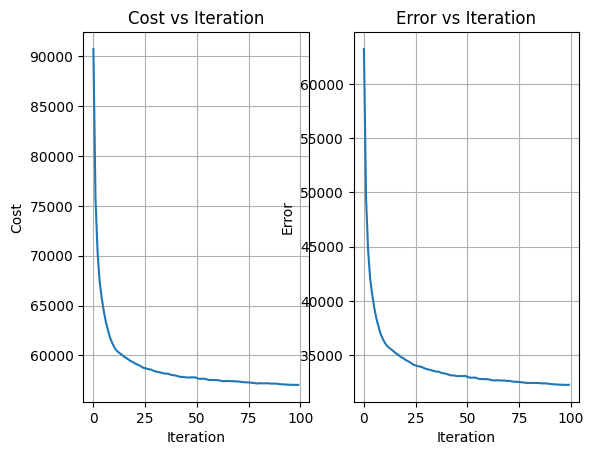

In [71]:
plt.subplot(1, 2, 1)
plt.plot(cost)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost vs Iteration')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(error)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error vs Iteration')
plt.grid()

plt.show()

In [ ]:
df = pd.DataFrame(X)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
df_hat = pd.DataFrame(X_hat_rounded)
df_hat.head()

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,4.0,3.0,4.0,4.0,3.0,5.0,4.0,3.0,4.0,4.0,...,1.0,2.0,1.0,1.0,2.0,0.0,1.0,1.0,2.0,3.0
1,5.0,4.0,-1.0,4.0,3.0,4.0,4.0,5.0,4.0,2.0,...,2.0,1.0,2.0,1.0,2.0,0.0,1.0,1.0,2.0,2.0
2,2.0,4.0,5.0,4.0,3.0,-5.0,3.0,2.0,1.0,-0.0,...,1.0,1.0,3.0,2.0,2.0,0.0,1.0,1.0,2.0,2.0
3,4.0,4.0,6.0,3.0,4.0,6.0,4.0,4.0,5.0,7.0,...,1.0,3.0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,3.0
4,4.0,3.0,2.0,5.0,1.0,5.0,5.0,3.0,2.0,5.0,...,1.0,1.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,2.0


**Comment:**
According to the results, we can conclude that this method of matrix factorization cannot have an accurate estimation on non-positive (unknown) ratings. These values affects $\mathbb{p}_u$ and $\mathbb{q}_i$. Due to this issue, the cost and error values are high, however its performance on estimating the rating of rated items is acceptable.

#**Exercise 2: Traveling Salesman Problem**


In [3]:
def parse_tsplib(file_path):
    """
    Parses a TSPLIB file and extracts city coordinates.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Extract node coordinates
    coord_section = False
    coordinates = []

    for line in lines:
        line = line.strip()
        if line.startswith("NODE_COORD_SECTION"):
            coord_section = True
            continue
        if line.startswith("EOF") or line == "":
            coord_section = False
        if coord_section:
            parts = line.split()
            coordinates.append((int(parts[0]), float(parts[1]), float(parts[2])))

    return coordinates

**Part 1) Simulated Annealing Method**

Simulated Annealing is a heuristic optimization technique inspired by the annealing process in metallurgy, where materials are slowly cooled to reach a stable, low-energy state. In the context of the provided code, it aims to solve the Traveling Salesman Problem (TSP) by iteratively improving a tour of cities. The algorithm starts with a random tour and calculates its total distance. At each iteration, a new tour is generated using one of three mutation methods: swapping two cities, removing and reinserting a city, or reversing a subsequence. The new tour is accepted if it improves the total distance or probabilistically if it is worse, based on a temperature parameter. The temperature gradually decreases with each iteration, reducing the likelihood of accepting worse solutions over time. This balance between exploration (accepting worse solutions early) and exploitation (focusing on improving solutions later) allows the algorithm to escape local optima and approach a near-optimal solution. The process concludes with the shortest tour found during the iterations.

In [4]:
def distance(city1, city2):
    """
    Calculates the Euclidean distance between two cities.
    """
    x1, y1 = city1[1], city1[2]
    x2, y2 = city2[1], city2[2]
    d = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return d

def tour_length(tour, cities):
    """
    Calculates the total distance of a tour.
    """
    total_distance = 0
    for i in range(len(tour) - 1):
        city1 = cities[tour[i]]
        city2 = cities[tour[i + 1]]
        total_distance += distance(city1, city2)
    total_distance += distance(cities[tour[0]], cities[tour[-1]])

    return total_distance

def generate_new_tour(tour, method):
    """
    Generates a new tour.
    method = 1: Chooses two cities at random and swap them.
    method = 2: Removes a city from its current position, then randomly inserts it at another position.
    method = 3: Chooses a random subsequence of our tour, and then reverses the subsequence.
    """
    if method == 1:
      i, j = np.random.choice(len(tour), 2, replace=False)
      new_tour = tour.copy()
      new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
    elif method == 2:
      i, j = np.random.choice(len(tour), 2, replace=False)
      new_tour = tour.copy()
      selected_city = new_tour[i];
      new_tour = np.delete(new_tour, i)
      new_tour = np.insert(new_tour, j, selected_city)
    elif method == 3:
      i = np.random.randint(0, len(tour)-1)
      sub_seq_len = np.random.randint(2, len(tour[i:]) + 1)
      new_tour = tour.copy()
      sub_seq = new_tour[i : i + sub_seq_len]
      sub_seq_reverse = sub_seq[::-1]
      new_tour[i : i + sub_seq_len] = sub_seq_reverse
    return new_tour

def simulated_annealing(cities, num_iterations, initial_temperature, cooling_rate, method):
    """
    Solves the TSP using the simulated annealing method.
    method = 1: We choose two cities at random and swap them.
    method = 2: We remove a city from its current position, then randomly insert it at another position.
    method = 3: We choose a random subsequence of our tour, and then we reverse the subsequence.
    """
    current_tour = np.random.permutation(len(cities))
    best_tour = current_tour.copy()
    current_length = tour_length(current_tour, cities)
    best_length = current_length
    temperature = initial_temperature
    for i in range(num_iterations):
      new_tour = generate_new_tour(current_tour, method)
      new_length = tour_length(new_tour, cities)
      if new_length < current_length or np.random.rand() < np.exp(-(new_length - current_length) / temperature):
        current_tour = new_tour
        current_length = new_length
        if current_length < best_length:
          best_tour = current_tour.copy()
          best_length = current_length
      temperature *= cooling_rate
    return best_tour, best_length

In [5]:
file_path = "berlin52.tsp"  # Update with your file's path
cities = parse_tsplib(file_path)
print(cities)

[(1, 565.0, 575.0), (2, 25.0, 185.0), (3, 345.0, 750.0), (4, 945.0, 685.0), (5, 845.0, 655.0), (6, 880.0, 660.0), (7, 25.0, 230.0), (8, 525.0, 1000.0), (9, 580.0, 1175.0), (10, 650.0, 1130.0), (11, 1605.0, 620.0), (12, 1220.0, 580.0), (13, 1465.0, 200.0), (14, 1530.0, 5.0), (15, 845.0, 680.0), (16, 725.0, 370.0), (17, 145.0, 665.0), (18, 415.0, 635.0), (19, 510.0, 875.0), (20, 560.0, 365.0), (21, 300.0, 465.0), (22, 520.0, 585.0), (23, 480.0, 415.0), (24, 835.0, 625.0), (25, 975.0, 580.0), (26, 1215.0, 245.0), (27, 1320.0, 315.0), (28, 1250.0, 400.0), (29, 660.0, 180.0), (30, 410.0, 250.0), (31, 420.0, 555.0), (32, 575.0, 665.0), (33, 1150.0, 1160.0), (34, 700.0, 580.0), (35, 685.0, 595.0), (36, 685.0, 610.0), (37, 770.0, 610.0), (38, 795.0, 645.0), (39, 720.0, 635.0), (40, 760.0, 650.0), (41, 475.0, 960.0), (42, 95.0, 260.0), (43, 875.0, 920.0), (44, 700.0, 500.0), (45, 555.0, 815.0), (46, 830.0, 485.0), (47, 1170.0, 65.0), (48, 830.0, 610.0), (49, 605.0, 625.0), (50, 595.0, 360.0), (

In [11]:
methods = {'Swap Method': 1, 'Insert Method': 2, 'Reverse Method': 3}
for method_name, m in methods.items():
  best_tour, best_length = simulated_annealing(cities, num_iterations = 10000, initial_temperature = 1000, cooling_rate = 0.95, method = m)
  print(f'Best Tour for {method_name} is {best_tour}')
  print()
  print(f'Best Length {method_name} is {best_length}')
  print()

Best Tour for Swap Method is [50 10 26 27 11 24 39 44  7 40 18 31 48 17 30 20 41  6  1 28 46 13 51 12
 25 22 21  0 34 38 36 23  4 14  5  3 32 42 37 47 45 43 33 35  9  8  2 16
 29 19 49 15]

Best Length Swap Method is 11439.781013447418

Best Tour for Insert Method is [12 13 51 10 50 11  5 14  4 23 47 37 39 36 33 34 48 31  2 17 30 20 16  6
  1 41 29 22 19 49 15 28 46 25 24  3 42 32  9  8  7 40 18 44 38 35 21  0
 43 45 27 26]

Best Length Insert Method is 8981.867242511187

Best Tour for Reverse Method is [47 23  5  3 14  4 37 39 38 35 48 21  0 43 49 19 29 22 30 17 20 41  1  6
 16  2 31 44 18 40  7  8  9 42 32 50 10 11 24 27 25 26 12 51 13 46 28 15
 45 33 34 36]

Best Length Reverse Method is 8865.873824916227



**Comment:**
According to the result, After 10000 iterations with initial temperature T = 1000, cooling rate $\alpha$ = 0.95, the third method, reversing a random subsequence, achieves the best lengh among all methods. It shows that this method is able to explore more through all possible tours and finds the best one. However, its implementation is more complex in comparison with other methods.

**Part 2) Genetic Algorithm**

The Genetic Algorithm (GA) implemented in this code aims to solve the Traveling Salesman Problem (TSP) by generating new generations of chromosomes. The algorithm begins with a randomly generated population of tours, evaluates their fitness based on the total tour length, and selects parents using rank-based selection. New offspring are generated through crossover methods, including Ordered Crossover (OX) to preserve subsequences of cities, Position-Based Crossover (PBX) to transfer specific positions, and Cyclic Crossover (CX) to maintain positional cycles. To maintain diversity, mutations are applied with a set probability, using techniques like Inversion Mutation (reversing a subsequence), Exchange Mutation (swapping two cities), and Random Resetting Mutation (moving a city to a new position). The population is updated each generation, with the best solutions carried forward to ensure elitism. After a fixed number of iterations, the algorithm outputs the best tour and its length, leveraging a combination of exploration (crossover) and exploitation (mutation) for optimization.

In [12]:
def population_generation(cities, population_size):
  """
    Generates a population of random tours.
  """
  # Total number of cities
  num_cities = len(cities)

  # Population of random tours generation
  population = np.array([np.random.permutation(num_cities) for _ in range(population_size)])

  return population

In [13]:
def selection(population, population_size, num_parents):
  """
    Selects parents using Rank Selection.
  """
  # Rank the tours in the population based on their length
  population_tour_length = np.array([tour_length(tour, cities) for tour in population])
  ranks = np.argsort(population_tour_length)

  # Compute selection probabilities based on rank
  probabilities = np.array([
      2 * (population_size - rank + 1) / (population_size * (population_size + 1))
      for rank in range(1, population_size + 1)])

  # Normalize probabilities to ensure they sum to 1
  probabilities /= probabilities.sum()

  # Select parents using probabilities
  selected_indices = np.random.choice(population_size, size = num_parents, replace=True, p = probabilities)
  parents = [population[i] for i in selected_indices]

  return ranks, parents

In [14]:
def crossover(parent1, parent2, crossover_method):
  """
    Performs crossover between two tours.
    Crossover method = 1: Ordered Crossover
    Crossover method = 2: Position-Based Crossover
    Crossover method = 3: Cyclic Crossover
  """
  # Initialization of offsprings
  offspring1 = [None] * len(parent1)
  offspring2 = [None] * len(parent2)

  if crossover_method == 1: # Ordered Crossover
    # Copy the substring
    start, end = sorted(np.random.choice(len(parent1), 2, replace=False))
    offspring1[start:end+1] = parent1[start:end+1]
    offspring2[start:end+1] = parent2[start:end+1]

    # Identify unfilled positions in offspring
    unfilled_positions1 = [i for i, gene in enumerate(offspring1) if gene is None]
    unfilled_positions2 = [i for i, gene in enumerate(offspring2) if gene is None]

    # Identify remaining cities
    remaining_cities1 = [city for city in parent2 if city not in offspring1[start:end+1]]
    remaining_cities2 = [city for city in parent1 if city not in offspring2[start:end+1]]

    # Assign remaining cities to unfilled positions
    for pos, city in zip(unfilled_positions1, remaining_cities1):
        offspring1[pos] = city

    for pos, city in zip(unfilled_positions2, remaining_cities2):
        offspring2[pos] = city

  elif crossover_method == 2: # Position-Based Crossover

    # Choose crossover positions
    subset_size = np.random.randint(1, len(parent1))
    subset_idx = np.random.choice(len(parent1), subset_size, replace=False)

    # Copy subset from parents to offspring
    for idx in subset_idx:
      offspring1[idx] = parent1[idx]
      offspring2[idx] = parent2[idx]

    # Fill remaining positions for offspring1
    remaining_cities1 = [city for city in parent2 if city not in offspring1]
    current_pos = 0
    for city in remaining_cities1:
      while offspring1[current_pos] is not None:
          current_pos += 1
      offspring1[current_pos] = city

    # Fill remaining positions for offspring2
    remaining_cities2 = [city for city in parent1 if city not in offspring2]
    current_pos = 0
    for city in remaining_cities2:
        while offspring2[current_pos] is not None:
            current_pos += 1
        offspring2[current_pos] = city

  elif crossover_method == 3: # Cyclic Crossover

    def cyclic_crossover(parent1, parent2, offspring1):
      # Determine the cycle
      current_pos = 0
      cycle_indices = []
      cycle = []
      counter = 1
      while True :
        cycle_indices.append(current_pos)
        if current_pos == 0:
          cycle.append(parent1[current_pos])
          cycle.append(parent2[current_pos])
        current_pos = np.where(np.array(parent1) == parent2[current_pos])[0][0]
        cycle.append(parent2[current_pos])
        counter += 1
        if cycle[counter] == cycle[0]:
          cycle_indices.append(current_pos)
          break

      # Copy the cycle elements in offspring
      for idx in cycle_indices:
        offspring1[idx] = parent1[idx]

      # Fill remaining positions for offspring
      remaining_cities1 = [city for city in parent2 if city not in offspring1]
      i = 0
      for city in remaining_cities1:
        while offspring1[i] is not None:
            i += 1
        offspring1[i] = city
      return offspring1

    offspring1 = cyclic_crossover(parent1, parent2, offspring1)
    offspring2 = cyclic_crossover(parent2, parent1, offspring2)

  return offspring1, offspring2

In [15]:
def mutation(tour, mutation_mode):
  """
    Performs mutation on a tour.
    Mutation method = 1: Inversion Mutation
    Mutation method = 2: Exchange Mutation
    Mutation method = 3: Random Resetting Mutation
  """
  if mutation_mode == 1: # Inversion Mutation
    start, end = sorted(np.random.choice(len(tour), 2, replace=False))
    new_tour = tour.copy()
    sub_tour = new_tour[start : end + 1]
    sub_tour_reverse = sub_tour[::-1]
    new_tour[start : end + 1] = sub_tour_reverse

  elif mutation_mode == 2: # Exchange Mutation
    i, j = np.random.choice(len(tour), 2, replace=False)
    new_tour = tour.copy()
    new_tour[i], new_tour[j] = new_tour[j], new_tour[i]

  elif mutation_mode == 3: # Random Resetting Mutation
    i, j = np.random.choice(len(tour), 2, replace=False)
    new_tour = tour.copy()
    selected_city = new_tour[i];
    new_tour = np.delete(new_tour, i)
    new_tour = np.insert(new_tour, j, selected_city)

  return new_tour

In [16]:
def genetic_algorithm(cities, num_iterations, population_size, mutation_rate, crossover_method = 1, mutation_mode = 1):
    """
    Solves the TSP using the genetic algorithm with rank selection of parents.
    """
    # Population generation
    population = population_generation(cities, population_size)

    # The best tour initialization
    population_tour_lengths = np.array([tour_length(tour, cities) for tour in population])
    best_tour_idx = np.argmin(population_tour_lengths)
    best_tour = population[best_tour_idx]
    best_length = population_tour_lengths[best_tour_idx]

    for i in range(num_iterations):
      new_population = []
      # Rank selection
      ranks, parents = selection(population, population_size, population_size)

      # Create offsprings
      for j in range(0, len(parents), 2):
        if j + 1 < len(parents):  # Ensure pairs are complete
            parent1 = parents[j]
            parent2 = parents[j + 1]

            # Apply crossover to generate offspring
            offspring1, offspring2 = crossover(parent1, parent2, crossover_method)

            # Apply mutation with a probability
            if np.random.rand() < mutation_rate:
                offspring1 = mutation(offspring1, mutation_mode)
            if np.random.rand() < mutation_rate:
                offspring2 = mutation(offspring2, mutation_mode)

            # Add offspring to the new population
            new_population.extend([offspring1, offspring2])

      # Replace old population with new Population
      new_population_tour_lengths = np.array([tour_length(tour, cities) for tour in new_population])
      for j in range(population_size):
        if new_population_tour_lengths[j] < population_tour_lengths[j]:
          population[j] = new_population[j]
          population_tour_lengths[j] = new_population_tour_lengths[j]
      # Find the best tour
      best_tour_idx = np.argmin(population_tour_lengths)
      best_tour = population[best_tour_idx]
      best_length = population_tour_lengths[best_tour_idx]

    return best_tour, best_length

In [ ]:
file_path = "berlin52.tsp"  # Update with your file's path
cities = parse_tsplib(file_path)
print(cities)

[(1, 565.0, 575.0), (2, 25.0, 185.0), (3, 345.0, 750.0), (4, 945.0, 685.0), (5, 845.0, 655.0), (6, 880.0, 660.0), (7, 25.0, 230.0), (8, 525.0, 1000.0), (9, 580.0, 1175.0), (10, 650.0, 1130.0), (11, 1605.0, 620.0), (12, 1220.0, 580.0), (13, 1465.0, 200.0), (14, 1530.0, 5.0), (15, 845.0, 680.0), (16, 725.0, 370.0), (17, 145.0, 665.0), (18, 415.0, 635.0), (19, 510.0, 875.0), (20, 560.0, 365.0), (21, 300.0, 465.0), (22, 520.0, 585.0), (23, 480.0, 415.0), (24, 835.0, 625.0), (25, 975.0, 580.0), (26, 1215.0, 245.0), (27, 1320.0, 315.0), (28, 1250.0, 400.0), (29, 660.0, 180.0), (30, 410.0, 250.0), (31, 420.0, 555.0), (32, 575.0, 665.0), (33, 1150.0, 1160.0), (34, 700.0, 580.0), (35, 685.0, 595.0), (36, 685.0, 610.0), (37, 770.0, 610.0), (38, 795.0, 645.0), (39, 720.0, 635.0), (40, 760.0, 650.0), (41, 475.0, 960.0), (42, 95.0, 260.0), (43, 875.0, 920.0), (44, 700.0, 500.0), (45, 555.0, 815.0), (46, 830.0, 485.0), (47, 1170.0, 65.0), (48, 830.0, 610.0), (49, 605.0, 625.0), (50, 595.0, 360.0), (

In [17]:
crossover_methods = {'Ordered Crossover': 1, 'Position-Based Crossover': 2, 'Cyclic Crossover': 3}
mutation_modes ={'Inversion Mutation': 1, 'Exchange Mutation': 2, 'Random Resetting Mutation': 3}
for crossover_name, cm in crossover_methods.items():
  for mutation_name, mm in mutation_modes.items():
    best_tour, best_length = genetic_algorithm(cities, num_iterations = 1000, population_size = 100, mutation_rate = 0.1, crossover_method = cm, mutation_mode = mm)
    print(f'Best Tour for {crossover_name} and {mutation_name} is {best_tour}')
    print(f'Best Length for {crossover_name} and {mutation_name} is {best_length}')
    print()

Best Tour for Ordered Crossover and Inversion Mutation is [28 15 43 34 35 33 45 24 11 27 26 25 46 12 13 51 10 50 32 42  3  5 14  4
 23 47 37 36 39 38  9  8  7 40 18 44 31 48  0 21 30 17  2 16  6  1 41 20
 22 29 19 49]
Best Length for Ordered Crossover and Inversion Mutation is 8153.85732058131

Best Tour for Ordered Crossover and Exchange Mutation is [39 38 35 34 48  0 21 30 17 31 44 18  7  9  8 40  2 16 20 41  6  1 29 22
 19 43 33 36 37 14  3  5  4 23 47 15 28 49 45 24 10 51 13 12 46 25 26 27
 11 50 32 42]
Best Length for Ordered Crossover and Exchange Mutation is 8896.45241994998

Best Tour for Ordered Crossover and Random Resetting Mutation is [28 25 26 10 50 11 45 33 34 35 48 31  0 21 30 17 44 42 32  3  5 14  4 36
 43 22 19 49 15 46 13 51 12 27 24 47 23 37 39 38  9  8  7 40 18  2 16 20
 41  6  1 29]
Best Length for Ordered Crossover and Random Resetting Mutation is 9994.842312014807

Best Tour for Position-Based Crossover and Inversion Mutation is [24 11 27 26 25 46 12 13 51 10 50 

**Comment:** According to the results, after 1000 iterations with population size of 100 and mutation rate of 0.1, we observe the impact of different crossover and mutation methods on optimization performance. The combination of Ordered Crossover and Inversion Mutation excels in terms of performance by effectively balancing exploration and exploitation, thereby increasing the likelihood of finding optimal or near-optimal solutions.

**Part 3) Ant Colony Method**

The code implements the Ant Colony Optimization (ACO) algorithm to solve the Traveling Salesperson Problem (TSP) by simulating the behavior of ants exploring paths and reinforcing good solutions using pheromone trails. Ants start at random cities and construct tours by probabilistically selecting the next city based on pheromone levels (indicating previous success) and heuristic information (favoring shorter distances). The pheromone trails are updated iteratively, with evaporation to avoid getting stuck on poor solutions and reinforcement based on the quality of tours. Two versions of ACO are compared: the Standard Ant System (SAS), where all ants contribute to pheromone updates equally, and the Elitist Ant System (EAS), which gives additional weight to the globally best tour to accelerate convergence. SAS emphasizes exploration by relying on collective contributions, while EAS focuses on exploitation of the best solution, often leading to faster convergence. This balance between exploration and exploitation highlights the key trade-off in ACO algorithms.



*   **Standard Ant System (AS) Pheromone Update**
  The pheromone update rule for the standard Ant System is:

  $
  \tau_{ij} \leftarrow (1 - \rho) \tau_{ij} + \sum_{k=1}^{K} \Delta \tau_{ij}^k
  $

  Where:

  $
  \Delta \tau_{ij}^k = \begin{cases}
  \displaystyle \frac{Q}{L_k} & \text{if ant } k \text{ uses edge } (i,j) \text{ in its tour} \\
  0 & \text{otherwise}
  \end{cases}
  $
*   **Elitist Ant System (EAS) Pheromone Update**  
  The pheromone update rule for the Elitist Ant System is:  

  $
  \tau_{ij} \leftarrow (1 - \rho) \tau_{ij} + \sum_{k=1}^{m} \Delta \tau_{ij}^k + e \cdot \Delta \tau_{ij}^{\text{best}}
  $

  Where:  

  $
  \Delta \tau_{ij}^k = \begin{cases}
  \displaystyle \frac{Q}{L_k} & \text{if ant } k \text{ uses edge } (i,j) \text{ in its tour} \\
  0 & \text{otherwise}
  \end{cases}
  $

  $
  \Delta \tau_{ij}^{\text{best}} = \begin{cases}
  \displaystyle \frac{Q}{L_{\text{best}}} & \text{if edge } (i, j) \text{ is in the best tour}, \\
  0 & \text{otherwise}.
  \end{cases}
  $

  Where:  
  - $\rho$ is the pheromone evaporation rate, with $0 < \rho < 1$.  
  - $\tau_{ij}$ is the pheromone level on edge $(i,j)$.  
  - $K$ is the number of ants.  
  - $Q$ is a constant representing the amount of pheromone deposited.  
  - $L_k$ is the length of the tour constructed by ant $k $.  
  - $L_{\text{best}}$ is the length of the global best tour found so far.  
  - $n_e$ (elitist weight) is the number of elit ants, that have the minimum length of tour in their colony.  
  - $\Delta \tau_{ij}^k$ is the pheromone contribution from ant $k$.  
  - $\Delta \tau_{ij}^{\text{best}}$ is the pheromone contribution from the global best ant.

In [119]:
def distance_matrix(cities):
  """
    Computes the distance matrix between cities.
  """
  num_cities = len(cities)
  distance_matrix = np.zeros((num_cities, num_cities))
  for i in range(num_cities):
    for j in range(num_cities):
      if i != j:
        distance_matrix[i, j] = distance(cities[i], cities[j])
      else:
        distance_matrix[i, j] = np.inf
  return distance_matrix

def pheromone_matrix(num_cities):
  """
    Initializes the pheromone matrix with uniform value.
  """
  return np.ones((num_cities, num_cities))

def transition_probability(pheromone, distance, alpha, beta):
  """
    Computes the transition probability matrix.
  """
  num_cities = len(distance)
  fitness = 1 / (distance)  # Avoid division by zero
  P = (pheromone ** alpha) * (fitness ** beta)
  P = np.where(P > 0, P / P.sum(axis=1, keepdims=True), 0)  # Normalize probabilities row by row
  return P

def neighbor_selection(current_city, transition_prob_matrix, visited):
  """
    Selects the next city based on the transition probability.
  """
  transition_prob = transition_prob_matrix[current_city].copy()
  transition_prob[list(visited)] = 0  # Exclude visited cities

  total_prob = transition_prob.sum()
  if total_prob == 0:
    unvisited_cities = [city for city in range(len(transition_prob)) if city not in visited]
    return np.random.choice(unvisited_cities)

  transition_prob /= total_prob
  return np.random.choice(range(len(transition_prob)), p = transition_prob)

def pheromone_update(pheromone, ants_tours, best_tour_so_far, cities, pheromone_update_method, evaporation_rate, Q):
  """
    Updates the pheromone matrix.
    Pheromone Update Method = 1 : Update for Standard Ant System Algorithm
    Pheromone Update Method = 2 : Update for Elitist Ant System Algorithm
  """

  num_cities = len(pheromone)

  # Step 1) Evaporation of Pheromone Intensity (Negative Feedback)
  pheromone *= (1 - evaporation_rate)

  # Step 2) Update of Pheromone Intensity (Positive Feedback)
  for tour in ants_tours:
    tour_length_value = tour_length(tour, cities)  # Compute the length of the tour
    for i in range(len(tour) - 1):
      city_i = tour[i]
      city_j = tour[i + 1]
      delta_tau = Q / tour_length_value
      pheromone[city_i, city_j] += delta_tau
      pheromone[city_j, city_i] += delta_tau

    # Add pheromone for the return to the start city
    pheromone[tour[-1], tour[0]] += delta_tau
    pheromone[tour[0], tour[-1]] += delta_tau

    # Deposit additional pheromone on the edges of the best-so-far tour
    if pheromone_update_method == 2:
      best_length = tour_length(best_tour_so_far, cities)
      for i in range(len(best_tour_so_far) - 1):
        city_i = best_tour_so_far[i]
        city_j = best_tour_so_far[i + 1]
        delta_tau_best = Q / best_length
        pheromone[city_i, city_j] += delta_tau_best
        pheromone[city_j, city_i] += delta_tau_best
      # Add pheromone for the return to the start city (best tour)
      city_i = best_tour_so_far[-1]
      city_j = best_tour_so_far[0]
      delta_tau = Q / best_length
      pheromone[city_i, city_j] += delta_tau
      pheromone[city_j, city_i] += delta_tau

  return pheromone

def ant_colony_optimization(cities, num_ants, num_iterations, algorithm, evaporation_rate = 0.5, Q = 1, alpha = 1, beta = 2):
  """
    Solves the TSP using the Ant Colony Optimization algorithm.
    Algorithm = 1 : Standard Ant System Algorithm
    Algorithm = 2 : Elitist Ant System Algorithm
  """
  num_cities = len(cities) # Number of cities

  # Computation of the distance between cities
  distance_mat = distance_matrix(cities)

  # Pheromone matrix initialization
  pheromone_mat = pheromone_matrix(num_cities)

  # The best tour initialization
  best_tour = None
  best_length = float('inf')

  for iter in range(num_iterations):
    ants_tours = []

    # Ants' tours generation
    for ant in range(num_ants):
      current_city = np.random.randint(num_cities)
      tour = [current_city]
      visited = set(tour)
      for _ in range(num_cities - 1):
        transition_prob_matrix = transition_probability(pheromone_mat, distance_mat, alpha, beta)
        next_city = neighbor_selection(current_city, transition_prob_matrix, visited)
        tour.append(next_city)
        visited.add(next_city)
        current_city = next_city
      ants_tours.append(tour)

    # Update best tour
    ants_tours_length = [tour_length(tour, cities) for tour in ants_tours]
    best_current_length = min(ants_tours_length)
    best_current_tour = ants_tours[np.argmin(ants_tours_length)]
    if best_current_length < best_length:
      best_length = best_current_length
      best_tour = best_current_tour

    # Pheromone matrix update
    pheromone_mat = pheromone_update(pheromone_mat, ants_tours, best_tour, cities, algorithm, evaporation_rate, Q)


  return best_tour, best_length


In [110]:
file_path = "berlin52.tsp"  # Update with your file's path
cities = parse_tsplib(file_path)
print(cities)

[(1, 565.0, 575.0), (2, 25.0, 185.0), (3, 345.0, 750.0), (4, 945.0, 685.0), (5, 845.0, 655.0), (6, 880.0, 660.0), (7, 25.0, 230.0), (8, 525.0, 1000.0), (9, 580.0, 1175.0), (10, 650.0, 1130.0), (11, 1605.0, 620.0), (12, 1220.0, 580.0), (13, 1465.0, 200.0), (14, 1530.0, 5.0), (15, 845.0, 680.0), (16, 725.0, 370.0), (17, 145.0, 665.0), (18, 415.0, 635.0), (19, 510.0, 875.0), (20, 560.0, 365.0), (21, 300.0, 465.0), (22, 520.0, 585.0), (23, 480.0, 415.0), (24, 835.0, 625.0), (25, 975.0, 580.0), (26, 1215.0, 245.0), (27, 1320.0, 315.0), (28, 1250.0, 400.0), (29, 660.0, 180.0), (30, 410.0, 250.0), (31, 420.0, 555.0), (32, 575.0, 665.0), (33, 1150.0, 1160.0), (34, 700.0, 580.0), (35, 685.0, 595.0), (36, 685.0, 610.0), (37, 770.0, 610.0), (38, 795.0, 645.0), (39, 720.0, 635.0), (40, 760.0, 650.0), (41, 475.0, 960.0), (42, 95.0, 260.0), (43, 875.0, 920.0), (44, 700.0, 500.0), (45, 555.0, 815.0), (46, 830.0, 485.0), (47, 1170.0, 65.0), (48, 830.0, 610.0), (49, 605.0, 625.0), (50, 595.0, 360.0), (

In [121]:
ACS_Algorithm = {'Standard Ant System Algorithm': 1, 'Elitist Ant System Algorithm': 2}
for algorithm_name, algorithm_num in ACS_Algorithm.items():
  best_tour, best_length = ant_colony_optimization(cities, num_ants = 50, num_iterations = 1000, algorithm = algorithm_num)
  print(f'Best Tour for {algorithm_name} is {best_tour}')
  print(f'Best Length for {algorithm_name} is {best_length}')
  print()

Best Tour for Standard Ant System Algorithm is [0, 21, 30, 17, 2, 16, 20, 41, 6, 1, 29, 22, 19, 49, 28, 15, 45, 43, 33, 34, 35, 38, 39, 37, 36, 47, 23, 4, 14, 5, 3, 24, 11, 27, 26, 25, 46, 13, 12, 51, 10, 50, 32, 42, 9, 8, 7, 40, 18, 44, 31, 48]
Best Length for Standard Ant System Algorithm is 7549.289019371725

Best Tour for Elitist Ant System Algorithm is [24, 11, 50, 10, 51, 13, 12, 26, 27, 25, 46, 28, 29, 1, 6, 41, 20, 16, 2, 44, 18, 40, 7, 8, 9, 32, 42, 3, 5, 14, 4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 31, 48, 0, 21, 17, 30, 22, 19, 49, 15, 45]
Best Length for Elitist Ant System Algorithm is 7986.848408818598



**Part 4) Conclusion and Comparison:**


Based on the results obtained from implementing Simulated Annealing (SA), Genetic Algorithm (GA), and Ant Colony Optimization (ACO) on the Traveling Salesman Problem, I initially preferred the Ant Colony Optimization algorithm in terms of solution accuracy, as it achieved the shortest tour length of 7549.29. However, considering that the run time for the ACO algorithm is 5 minutes, run time becomes a significant factor in the overall evaluation. A the SA and GA algorithms have shorter run times while still providing reasonably good solutions (tour lengths of 8865.87 for SA and 8153.86 for GA), they might be more practical choices in time-sensitive scenarios. Therefore, balancing both solution accuracy and run time, the Genetic Algorithm with Ordered Crossover and Inversion Mutation emerges as a preferred option for its acceptable solution quality and potentially faster execution time compared to ACO. In cases where the highest solution accuracy is essential and longer computation time is acceptable, the ACO algorithm remains the best choice. Ultimately, the decision depends on the specific requirements regarding accuracy and computational resources for the problem at hand.

#**References:**

1. Prof. Michele Wigger. Class Lecture Notes on Optimization Theory.
Télécom Paris, University of Paris

2. István Pilászy, Dávid Zibriczky, Domonkos Tikk. "Fast ALS-based Matrix Factorization for Explicit and Implicit Feedback Datasets."
Gravity Research & Development, Humboldt-University of Berlin.
[Link](https://arxiv.org/pdf/1507.00333)

3. Rebirth4vali. "Implementing Matrix Factorization Technique for Recommender Systems from Scratch."
Medium.
[Link](https://medium.com/@rebirth4vali/implementing-matrix-factorization-technique-for-recommender-systems-from-scratch-7828c9166d3c)

4. Cheng, S. & Liu, X. "Research on Optimized Genetic Algorithm and Its Application in Logistics Distribution Center Location."
IEEE Xplore.
[Link](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8890891)

5. Wikipedia Contributors. "Selection (Genetic Algorithm)."
Wikipedia.
[Link](https://en.wikipedia.org/wiki/Selection_(genetic_algorithm))

6. Wikipedia Contributors. "Crossover (Genetic Algorithm)."
Wikipedia.
[Link](https://en.wikipedia.org/wiki/Crossover_(genetic_algorithm))

7. Wikipedia Contributors. "Mutation (Genetic Algorithm)."
Wikipedia.
[Link](https://en.wikipedia.org/wiki/Mutation_(genetic_algorithm))

8. GeeksforGeeks Contributors. "Crossover in Genetic Algorithm."
GeeksforGeeks.
[Link](https://www.geeksforgeeks.org/crossover-in-genetic-algorithm/)

9. GeeksforGeeks Contributors. "Mutation Algorithms for String Manipulation in Genetic Algorithms."
GeeksforGeeks.
[Link](https://www.geeksforgeeks.org/mutation-algorithms-for-string-manipulation-ga/)

10. YouTube Video: "Genetic Algorithm Tutorial (Part 1)."
[Link](https://www.youtube.com/watch?v=7hDZyH2E4Yw)

11. YouTube Video: "Genetic Algorithm Tutorial (Part 2)."
[Link](https://www.youtube.com/watch?v=EZg-l2FF-JM)

12. Alseda, L. "Genetic Operations."
Master's in Optimization, Universitat Autònoma de Barcelona.
[Link](https://mat.uab.cat/~alseda/MasterOpt/GeneticOperations.pdf)

13. AIgorithms. "Ant Colony Optimization Explained." YouTube. [Link](https://www.youtube.com/watch?v=jNd7QJQH-kk)

14. GeeksforGeeks. "Introduction to Ant Colony Optimization." [Link](https://www.geeksforgeeks.org/introduction-to-ant-colony-optimization/)

15. Wikipedia contributors. "Ant Colony Optimization Algorithms." Wikipedia. [Link](https://en.wikipedia.org/wiki/Ant_colony_optimization_algorithms)

16. Algorithm Afternoon. "Elitist Ant System." [Link](https://algorithmafternoon.com/ants/elitist_ant_system)
